In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import sympy as sm
import geomstats as gm

INFO: Using numpy backend


### Read Data

In [2]:
data = pd.read_csv("data/pass_rusher_features.csv")

In [3]:
data.y_smooth_pr.max()

51.77921803576193

In [2]:
from data.data_utils import process_data_play

In [5]:
processed_data = process_data_play(data[(data.nflId_pr == 41263) & (data.playId == 97) & (data.gameId == 2021090900)], partial_columns=["dx_smooth_pr", "dy_smooth_pr"], target_columns=["d2x_smooth_pr","d2y_smooth_pr"], position_columns=["x_smooth_pr", "y_smooth_pr"])

In [7]:
design_mat = processed_data[0]
target = processed_data[1]
gp_basis = processed_data[2]
dimension_id = processed_data[3]

In [9]:
design_mat[:,1] *= 2

### Fit Basic Christoffel Model

In [12]:
with pm.Model() as christoffel_model:
    sigma = pm.Exponential("sigma", 1, shape = (2,))

    length_scale = pm.Gamma("ls", 3, 7, shape = (2,))

    cov_func = pm.gp.cov.ExpQuad(2, ls=length_scale)
    gp = pm.gp.HSGP(m=[5, 5], c=4.0, cov_func=cov_func)
    basis_weights_x =  pm.math.stack([gp.prior(f"christoffel_symbol_x_{i}", X = gp_basis) for i in range(3)], axis = 0)
    basis_weights_y = pm.math.stack([gp.prior(f"christoffel_symbol_y_{i}", X = gp_basis) for i in range(3)], axis = 0)

    predicted_x = pm.math.sum(design_mat[dimension_id == 0,:] * basis_weights_x.T, axis = 1, keepdims=True)
    predicted_y = pm.math.sum(design_mat[dimension_id == 1,:] * basis_weights_y.T, axis = 1, keepdims=True)


    ### likelihood
    pm.Normal("likelihood_x", mu = predicted_x, 
              sigma = sigma[0], observed = -1 * target[dimension_id == 0,:])
    pm.Normal("likelihood_y", mu = predicted_y, 
              sigma = sigma[1], observed = -1 * target[dimension_id == 1,:])
    
with christoffel_model:
    trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ls, christoffel_symbol_x_0_hsgp_coeffs_, christoffel_symbol_x_1_hsgp_coeffs_, christoffel_symbol_x_2_hsgp_coeffs_, christoffel_symbol_y_0_hsgp_coeffs_, christoffel_symbol_y_1_hsgp_coeffs_, christoffel_symbol_y_2_hsgp_coeffs_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [26]:
cs_x = az.summary(trace, var_names=[f"christoffel_symbol_x_{i}" for i in range(3)])[["mean"]].to_numpy().reshape(175,3)
cs_y = az.summary(trace, var_names=[f"christoffel_symbol_y_{i}" for i in range(3)])[["mean"]].to_numpy().reshape(175,3)

In [27]:
cs_x

array([[ 2.26 ,  2.26 ,  2.262],
       [ 2.265,  2.267,  2.265],
       [ 2.257,  2.237,  2.203],
       [ 2.15 ,  2.073,  1.967],
       [ 1.831,  1.662,  1.46 ],
       [ 1.227,  0.965,  0.682],
       [ 0.382,  0.075, -0.231],
       [-0.527, -0.805, -1.057],
       [-1.277, -1.461, -1.607],
       [-1.715, -1.787, -1.824],
       [-1.831, -1.812, -1.772],
       [-1.716, -1.648,  2.26 ],
       [ 2.26 ,  2.262,  2.265],
       [ 2.267,  2.265,  2.257],
       [ 2.237,  2.203,  2.15 ],
       [ 2.073,  1.967,  1.831],
       [ 1.662,  1.46 ,  1.227],
       [ 0.965,  0.682,  0.382],
       [ 0.075, -0.231, -0.527],
       [-0.805, -1.057, -1.277],
       [-1.461, -1.607, -1.715],
       [-1.787, -1.824, -1.831],
       [-1.812, -1.772, -1.716],
       [-1.648,  2.26 ,  2.26 ],
       [ 2.262,  2.265,  2.267],
       [ 2.265,  2.257,  2.237],
       [ 2.203,  2.15 ,  2.073],
       [ 1.967,  1.831,  1.662],
       [ 1.46 ,  1.227,  0.965],
       [ 0.682,  0.382,  0.075],
       [-0

## Plot Results

In [29]:
import matplotlib.pyplot as plt

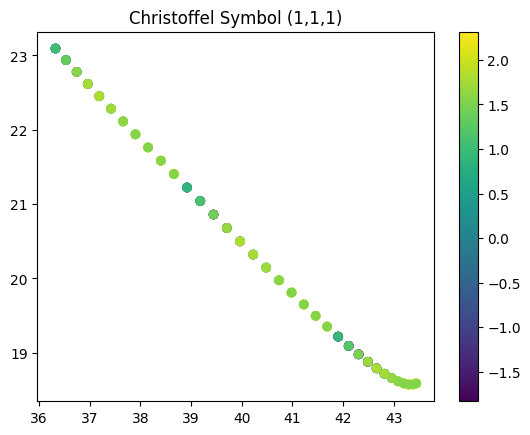

In [53]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_x[:,0],)
plt.title("Christoffel Symbol (1,1,1)")
plt.colorbar()

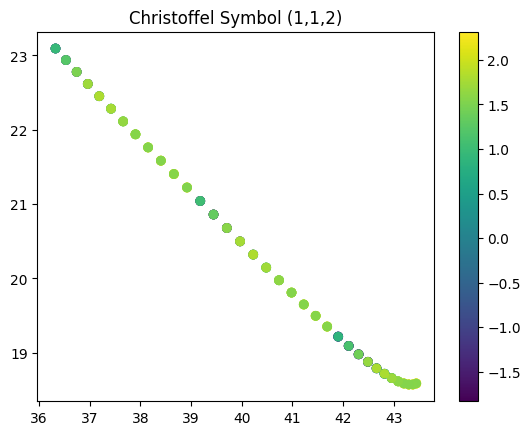

In [54]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_x[:,1])
plt.title("Christoffel Symbol (1,1,2)")
plt.colorbar()

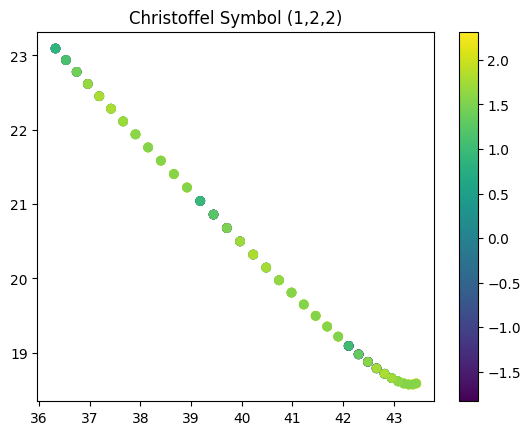

In [55]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_x[:,2])
plt.title("Christoffel Symbol (1,2,2)")
plt.colorbar()

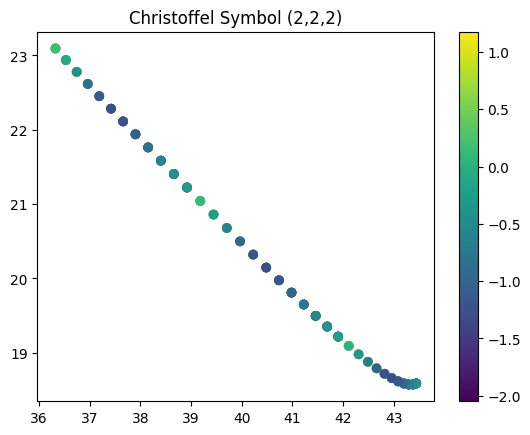

In [56]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_y[:,2])
plt.title("Christoffel Symbol (2,2,2)")
plt.colorbar()

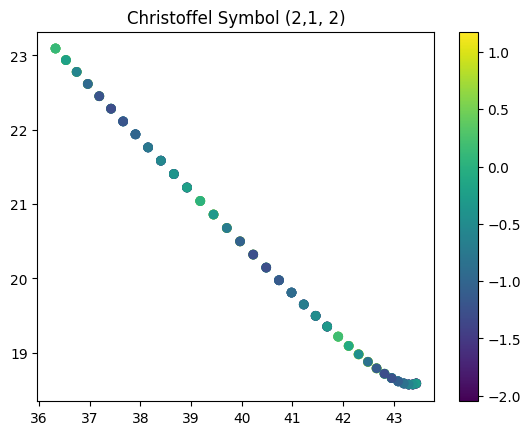

In [57]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_y[:,1])
plt.title("Christoffel Symbol (2,1, 2)")
plt.colorbar()

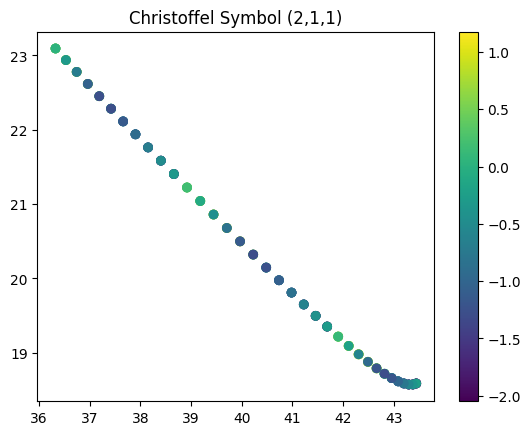

In [58]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_y[:,0])
plt.title("Christoffel Symbol (2,1,1)")
plt.colorbar()

## Generate Random Geodesics
Here, we will generate some geodesic samples from the following manifolds:
1. sphere
2. torus
3. hyperbeloid 

We will then attempt to recover the underlying metric from the sample of geodesics. We can also look at the following:
1. accuracy of recovery as a function of number of samples by geodesic
2. introduce noise and repeat above
3. Compare Christoffel Method vs. Metric Method

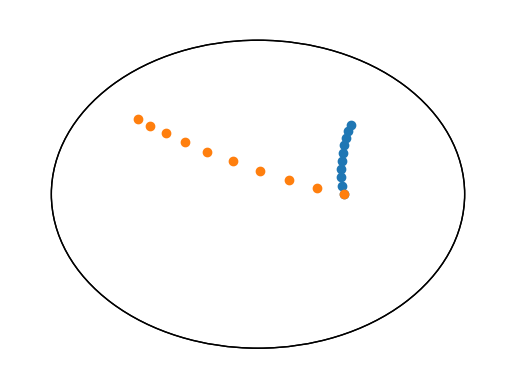

In [3]:
"""Plot a geodesic in H2.

Plot a geodesic on the hyperbolic space H2.
With Poincare Disk visualization.
"""
import matplotlib.pyplot as plt
import geomstats.visualization as visualization
from geomstats.geometry.hyperboloid import Hyperboloid


def plot_geodesic_between_two_points(
    space, initial_point, end_point, n_steps=10, ax=None
):
    """Plot the geodesic between two points."""

    if not space.belongs(initial_point):
        raise ValueError("The initial point of the geodesic is not in H2.")
    if not space.belongs(end_point):
        raise ValueError("The end point of the geodesic is not in H2.")

    geodesic = space.metric.geodesic(initial_point=initial_point, end_point=end_point)

    t = np.linspace(0.0, 1.0, n_steps)
    points = geodesic(t)
    visualization.plot(points, ax=ax, space="H2_poincare_disk")


def plot_geodesic_with_initial_tangent_vector(
    space, initial_point, initial_tangent_vec, n_steps=10, ax=None
):
    """Plot the geodesic with initial speed the tangent vector."""
    if not space.belongs(initial_point):
        raise ValueError("The initial point of the geodesic is not in H2.")
    geodesic = space.metric.geodesic(
        initial_point=initial_point, initial_tangent_vec=initial_tangent_vec
    )

    t = np.linspace(0.0, 1.0, n_steps)
    points = geodesic(t)
    visualization.plot(points, ax=ax, space="H2_poincare_disk")



"""Plot geodesics on H2."""
space = Hyperboloid(dim=2)

initial_point = np.array([np.sqrt(2.0), 1.0, 0.0])
end_point = np.array([1.5, 1.5])
end_point = space.from_coordinates(end_point, "intrinsic")
initial_tangent_vec = space.to_tangent(
vector=np.array([3.5, 0.6, 0.8]), base_point=initial_point
)

ax = plt.gca()
plot_geodesic_between_two_points(space, initial_point, end_point, ax=ax)
plot_geodesic_with_initial_tangent_vector(
space, initial_point, initial_tangent_vec, ax=ax
)
plt.show()




Above, we can plot the geodesic between two points on a manifold. Here, we chose the hyperbeloid, but we can experiment with a variety of manifolds

#### Generating Random Geodesics on a Sphere

In [3]:
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.euclidean import Euclidean

space = Hypersphere(dim=2)
# space = Euclidean(dim = 2)
time_steps  = 1000
t = np.linspace(0,1,time_steps)
N = 1
start_points = np.random.uniform(low=-1, high=1,size = (N,2))
end_points = np.random.uniform(low=-1,high=-1,size = (N,2))


projected_start_points = space.projection(start_points)
projected_end_points = space.projection(end_points)

geodesic = space.metric.geodesic(initial_point=projected_start_points, end_point=projected_end_points)
geodesic_trajectories = np.expand_dims(geodesic(t),0)

In [4]:
geodesic_trajectories.shape

(1, 1000, 2)

Now that we have the raw positional trajectories, we can convert them to the necessary values needed to estimate the christoffel symbols.

In [6]:
model_data = []
for k in range(N):
    velocities = np.gradient(geodesic_trajectories[k], 1/time_steps ,edge_order=2, axis = 0)
    accelerations = np.gradient(velocities, 1/time_steps, edge_order=2, axis = 0)
    velocity_df = pd.DataFrame(velocities, columns = [f"vel_{i}" for i in range(1,3)])
    acceleration_df = pd.DataFrame(accelerations, columns = [f"accel_{i}" for i in range(1,3)])
    position_df = pd.DataFrame(geodesic_trajectories[k], columns = [f"pos_{i}" for i in range(1,3)])
    full_df = pd.concat([position_df,acceleration_df,velocity_df], axis = 1)
    processed_trajectory_data = process_data_play(full_df, partial_columns=[f"vel_{i}" for i in range(1,3)],
                                              position_columns=[f"pos_{i}" for i in range(1,3)],
                                              target_columns=[f"accel_{i}" for i in range(1,3)])
    model_data.append(processed_trajectory_data)

total_design_matrix = np.vstack([item[0] for item in model_data])
total_target = np.vstack([item[1] for item in model_data])
total_position = np.vstack([item[2] for item in model_data])
total_dim_index = np.concatenate([item[3] for item in model_data])
total_design_matrix[:,1] *= 2
gp_basis = total_position.copy()

#### Fit Christoffel Model

In [9]:
with pm.Model() as christoffel_model:
    sigma = pm.Exponential("sigma", 1)

    # length_scale = pm.Gamma("ls", 3, 7, shape = (2,))

    # cov_func = pm.gp.cov.ExpQuad(2, ls=length_scale)
    cov_func = pm.gp.cov.ExpQuad(2, ls = np.array([.02,.02]))
    gp = pm.gp.HSGP(m=[50, 50], c=4.0, cov_func=cov_func)
    basis_weights_x =  pm.math.stack([gp.prior(f"christoffel_symbol_x_{i}", X = gp_basis) for i in range(3)], axis = 0)
    # basis_weights_y = pm.math.stack([gp.prior(f"christoffel_symbol_y_{i}", X = gp_basis) for i in range(3)], axis = 0)

    predicted_x = pm.math.sum(total_design_matrix[total_dim_index == 0,:] * basis_weights_x.T, axis = 1, keepdims=True)
    # predicted_y = pm.math.sum(total_design_matrix[total_dim_index == 1,:] * basis_weights_y.T, axis = 1, keepdims=True)


    ### likelihood
    pm.Normal("likelihood_x", mu = predicted_x, 
              sigma = sigma, observed = -1 * total_target[total_dim_index == 0,:])
    # pm.Normal("likelihood_y", mu = predicted_y, 
    #           sigma = sigma[1], observed = -1 * total_target[total_dim_index == 1,:])
    
    
with christoffel_model:
    vi_fit = pm.fit(n=50000)
    trace = vi_fit.sample()

Finished [100%]: Average Loss = 2,316.8
INFO: Finished [100%]: Average Loss = 2,316.8


In [11]:
cs_x = az.summary(trace, var_names=[f"christoffel_symbol_x_{i}" for i in range(3)])[["mean"]].to_numpy().reshape(1000,3)
# cs_y = az.summary(trace, var_names=[f"christoffel_symbol_y_{i}" for i in range(3)])[["mean"]].to_numpy().reshape(1000,3)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


In [12]:
az.summary(trace, var_names=["sigma"])

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,2.361,0.062,2.246,2.477,0.003,0.002,452.0,465.0,NaN


## Plot Results

In [13]:
import matplotlib.pyplot as plt

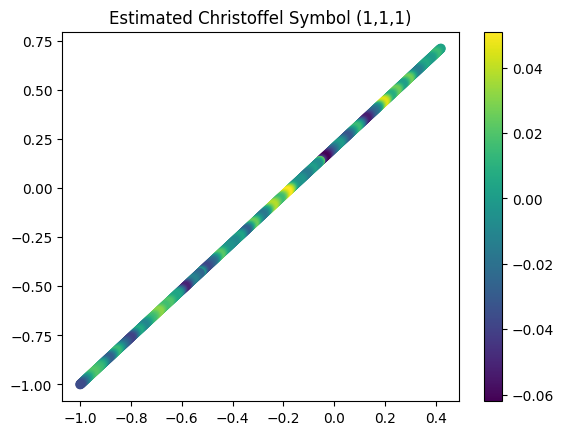

In [14]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_x[:,0],)
plt.title("Estimated Christoffel Symbol (1,1,1)")
plt.colorbar()

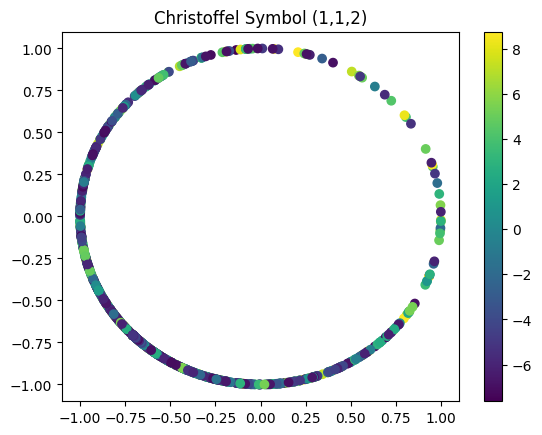

In [87]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_x[:,1])
plt.title("Christoffel Symbol (1,1,2)")
plt.colorbar()

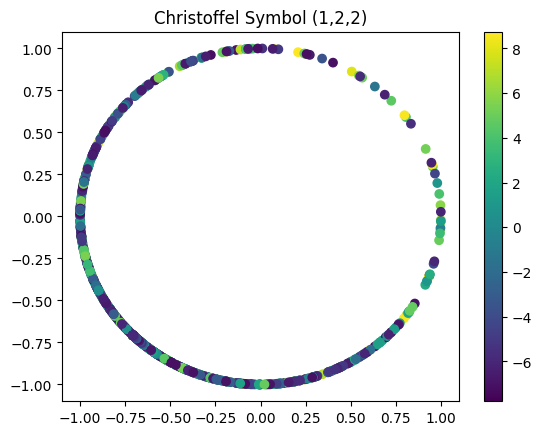

In [88]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_x[:,2])
plt.title("Christoffel Symbol (1,2,2)")
plt.colorbar()

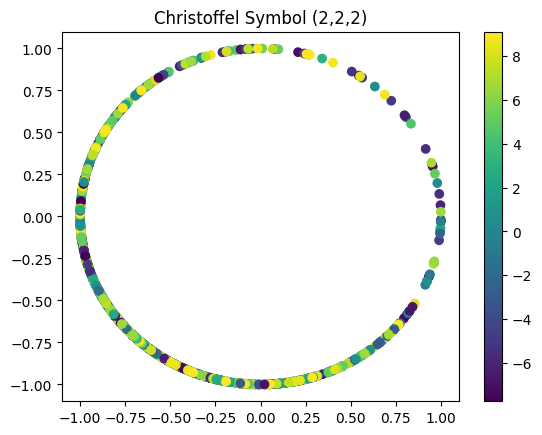

In [89]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_y[:,2])
plt.title("Christoffel Symbol (2,2,2)")
plt.colorbar()

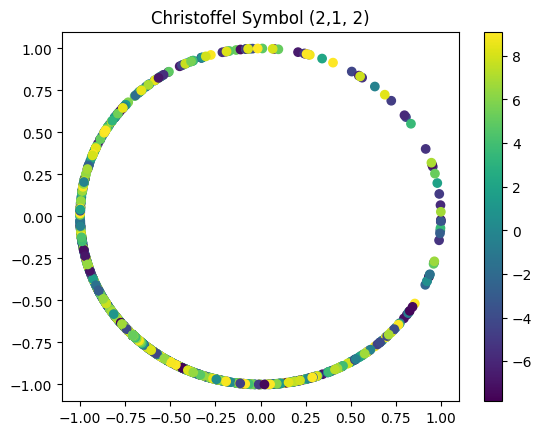

In [90]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_y[:,1])
plt.title("Christoffel Symbol (2,1, 2)")
plt.colorbar()

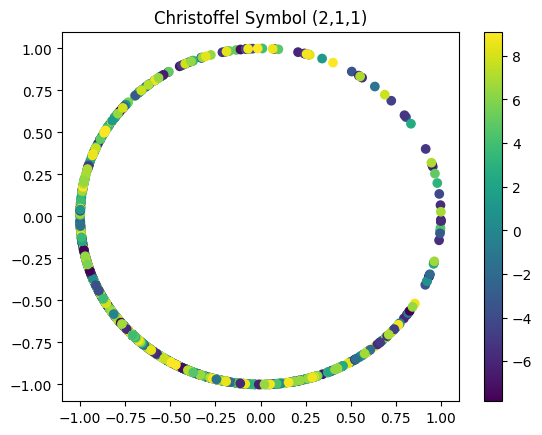

In [91]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_y[:,0])
plt.title("Christoffel Symbol (2,1,1)")
plt.colorbar()

In [92]:
def analytical_christoffel(x,y):
    return ((y**2)/(x**4))/((1 + (y/x)**2)**(5/2))

In [93]:
total_position

array([[-0.741098  , -0.67139687],
       [-0.74106486, -0.67143344],
       [-0.74103172, -0.67147002],
       ...,
       [-0.70708156, -0.70713201],
       [-0.70709417, -0.70711939],
       [-0.70710678, -0.70710678]])

In [94]:
vals = analytical_christoffel(total_position[:,0], total_position[:,1])

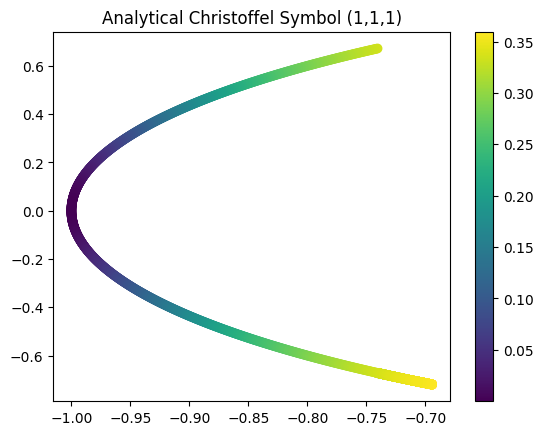

In [95]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = vals)
plt.title("Analytical Christoffel Symbol (1,1,1)")
plt.colorbar()

### Fit Using a Neural Network
The GP fit seems to be limited by the underlying distribution. We can try and use a Neural Network to approximate each of the Christoffel Symbols. 

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture for regression
class SimpleRegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the input size, hidden size, and output size
input_size = 2
hidden_size = 200
output_size = 3  # For regression with three outputs

# Create an instance of the model
model = SimpleRegressionNN(input_size, hidden_size, output_size)

# Print the model architecture
print(model)

# Define a sample input tensor
input_tensor = torch.from_numpy(total_position).to(torch.float32)

# Forward pass through the model
output_tensor = model(input_tensor)

# Print the output tensor shape
print("Output tensor shape:", output_tensor.shape)

# Define a squared error loss function and an optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Example training loop (you would replace this with your own data and training process)
for epoch in range(10):
    # Forward pass
    outputs = model(input_tensor)
    targets = torch.from_numpy(-1*total_target[total_dim_index == 0, :]).to(torch.float32)
    
    loss = criterion(torch.sum(outputs * torch.from_numpy(total_design_matrix[total_dim_index == 0,:]).to(torch.float32), axis = 1), targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for each epoch
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}")


SimpleRegressionNN(
  (fc1): Linear(in_features=2, out_features=200, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=200, out_features=3, bias=True)
)
Output tensor shape: torch.Size([1000, 3])
Epoch 1/10, Loss: 0.0405
Epoch 2/10, Loss: 20.0101
Epoch 3/10, Loss: 1.3126
Epoch 4/10, Loss: 4.1883
Epoch 5/10, Loss: 10.9062
Epoch 6/10, Loss: 8.1033
Epoch 7/10, Loss: 2.3784
Epoch 8/10, Loss: 0.0089
Epoch 9/10, Loss: 1.8392
Epoch 10/10, Loss: 4.4641


/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/curvature-estimation-aAq3osx7-py3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [16]:
predictions = model(input_tensor)

In [17]:
new_preds = predictions.detach().numpy()

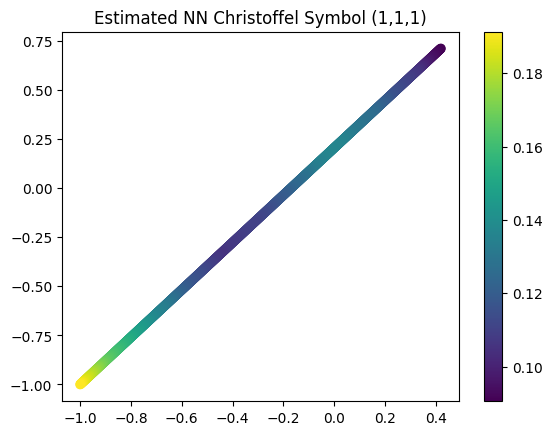

In [18]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = new_preds[:,0])
plt.title("Estimated NN Christoffel Symbol (1,1,1)")
plt.colorbar()

these results kind of suck, let's see if we can estimate the underlying metric instead

### Estimating the Metric
I will follow the approach used in my overleaf. Need to build a custom covariance class however to mark the derivative of our GP.

In [53]:
%load_ext autoreload
%autoreload 2
from models.basic_model import build_metric_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
model = build_metric_model(x_features = total_design_matrix[total_dim_index==0,:], y_features=total_design_matrix[total_dim_index==1,:], 
                           target_x=total_target[total_dim_index==0,:], target_y=total_target[total_dim_index == 1,:], points = gp_basis, m = 5)

In [56]:
with model:
    vi_fit = pm.fit()
    vi_samples = vi_fit.sample()